In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [10]:
#read data
data=pd.ExcelFile("/Users/suedy/Downloads/2_Data_Files.xlsx")
potato_info=pd.read_excel(data,"Potatoes_Info")
client_info=pd.read_excel(data,"Client_Info")
position=pd.read_excel(data,"Potatoes_Positions")
potato=position[["Date","Product ID","Price"]].merge(potato_info,how="left",left_on='Product ID',right_on='Product ID')
potato=potato.drop(["Variety Name"],axis=1)
potato=potato.drop_duplicates(subset=potato.columns.get_values().tolist())
for col in potato.columns.get_values().tolist()[3:]:
    potato[col] = potato[col].astype('category',copy=False)
potato=potato.dropna()
potato_price=pd.DataFrame({"Date":potato["Date"].unique(),
                          "Average Potato Price":potato.groupby("Date")["Price"].mean().tolist()})
product_id=potato["Product ID"].unique().tolist()
for i in product_id:
    p=potato[potato["Product ID"]==i].loc[:,["Date","Price"]]
    potato_price=pd.merge(potato_price,p,how="left",left_on="Date",right_on="Date")
    potato_price=potato_price.rename(columns={"Price":str(i)})
potato_price.head()

,Average Potato Price,Date,131,14,235,90,126,176,246,16,...,108,130,280,204,6,20,209,132,56,111
0,63.129748,2020-05-01,12.02,12.43,12.88,13.07,13.41,14.53,14.97,15.49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52.133053,2020-05-04,11.76,13.14,13.64,12.90,NaN,NaN,15.07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,51.450213,2020-05-05,11.24,12.46,12.90,12.42,NaN,NaN,15.11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,51.587340,2020-05-06,11.35,12.92,12.53,11.78,NaN,NaN,14.30,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,65.660902,2020-05-07,11.52,12.97,13.25,12.50,13.24,14.19,15.19,16.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, 'Product 45 Price')

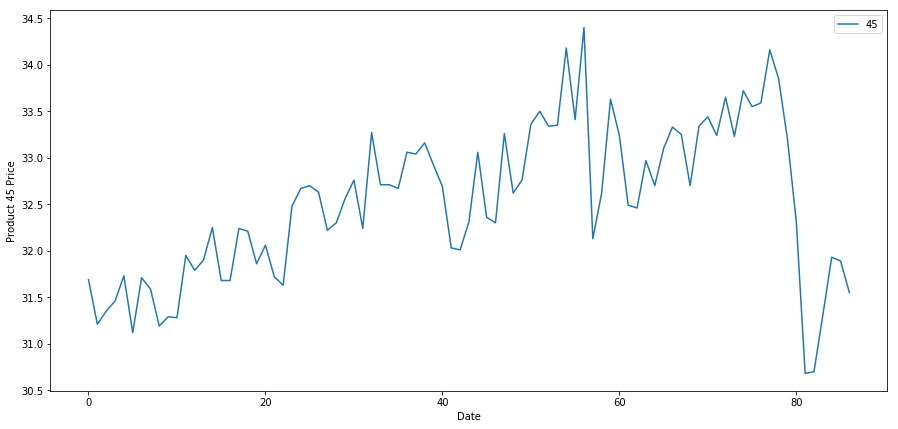

In [13]:
import matplotlib.pyplot as plt
p_45=potato_price[['45','Average Potato Price']]
p_45=p_45.drop("Average Potato Price",axis=1)
p_45.head()
d=p_45.values
fig, ax = plt.subplots(figsize=(15,7))
p_45.plot(ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Product 45 Price')

In [14]:
train = d[0:60,:]
valid = d[60:,:]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(p_45)
x_train, y_train = [], []
for i in range(4,len(train)):
    x_train.append(scaled_data[i-4:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [15]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
#predict using past 4 from the train data
inputs = p_45[len(p_45) - len(valid) - 4:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
X_test = []
for i in range(4,inputs.shape[0]):
    X_test.append(inputs[i-4:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 - 2s - loss: 0.0507


0.9079876954817374

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


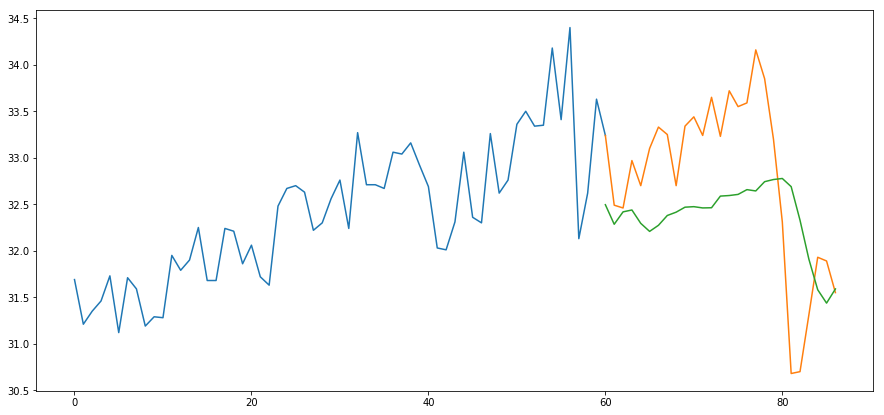

In [16]:
#for plotting
plt.figure(figsize=(15,7))
train = p_45[:61]
valid = p_45[60:]
valid['Predictions'] = closing_price
plt.plot(train['45'])
plt.plot(valid[['45','Predictions']])